<a href="https://colab.research.google.com/github/MehrdadJalali-AI/Spectrum/blob/main/ActualPredcitedCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape of spectraData: (4095, 1500)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Root Mean Squared Error (RMSE) on 1000 new spectra: 0.023623720781362056
R2 Score on 1000 new spectra: 0.9962481178861745


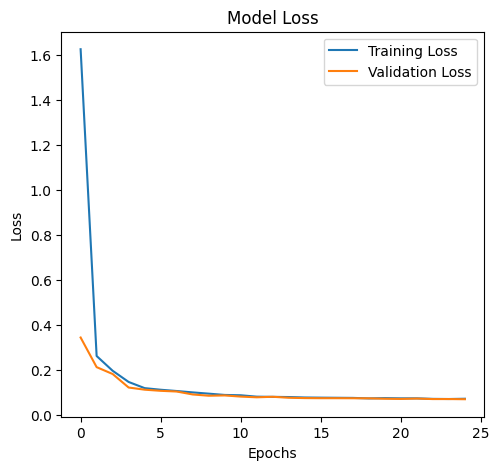

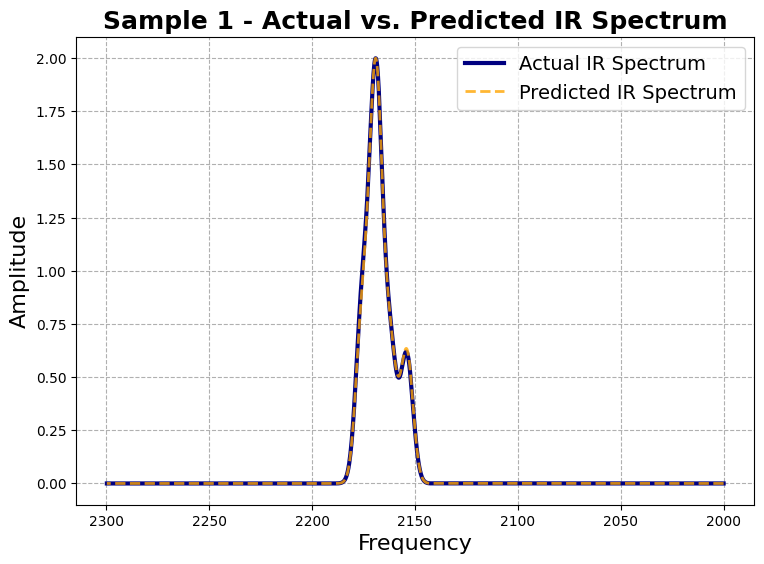

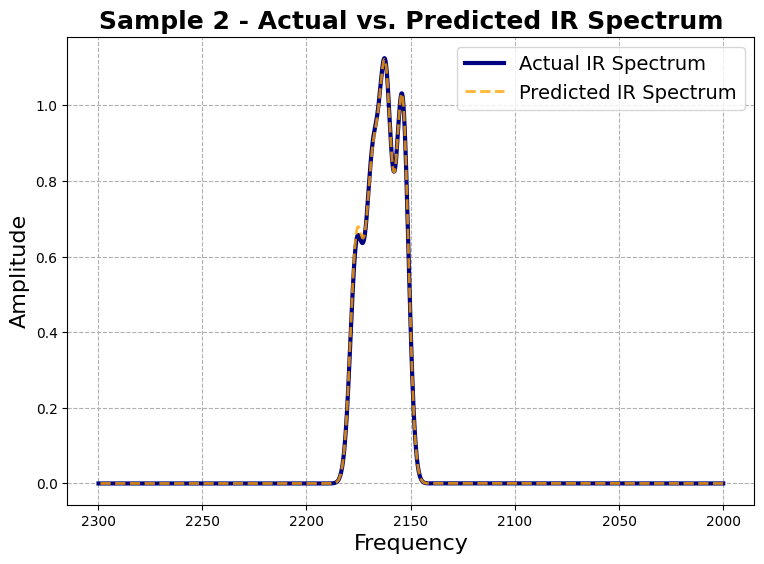

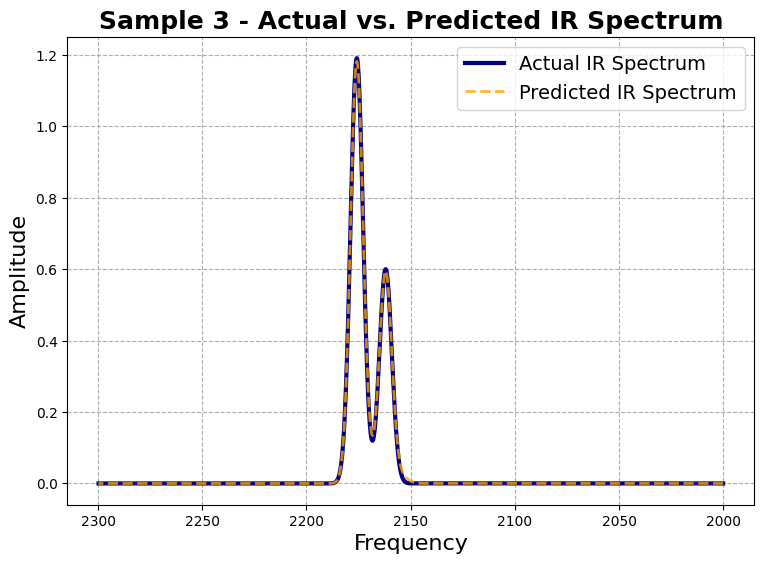

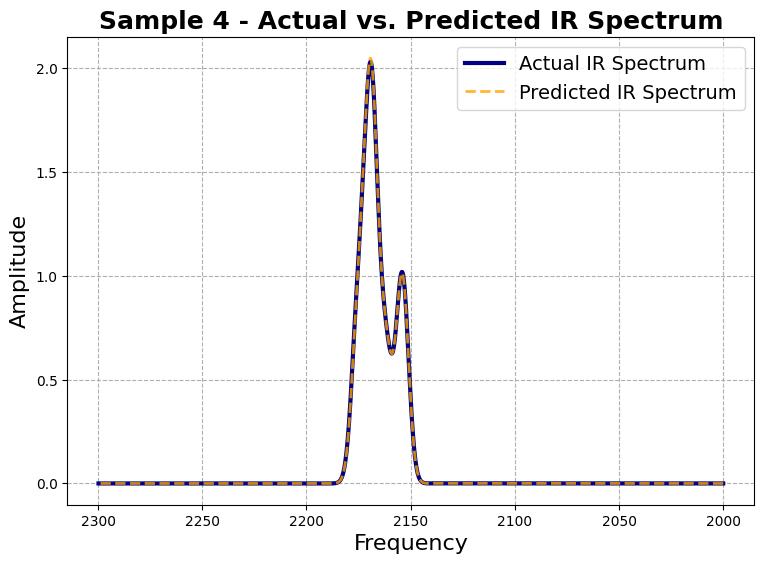

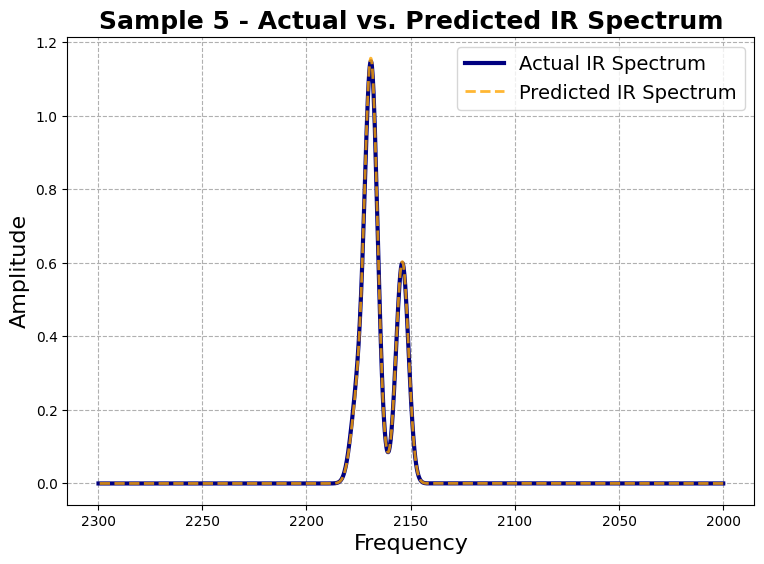

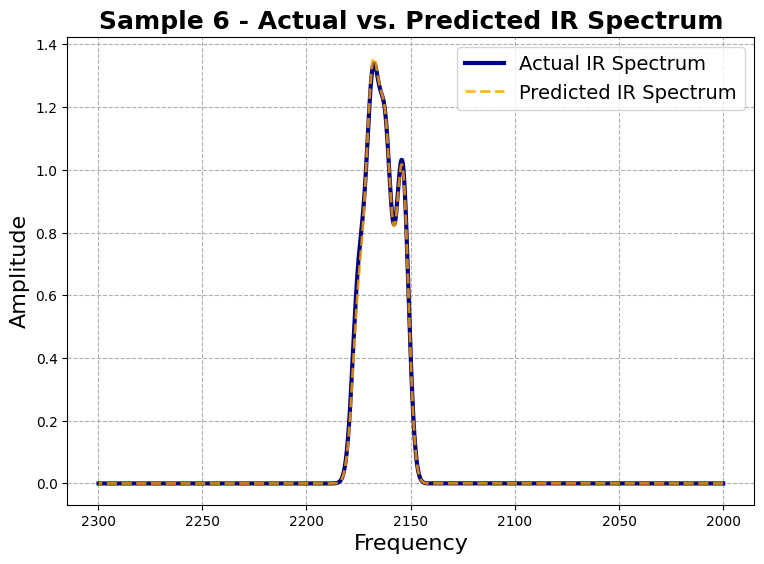

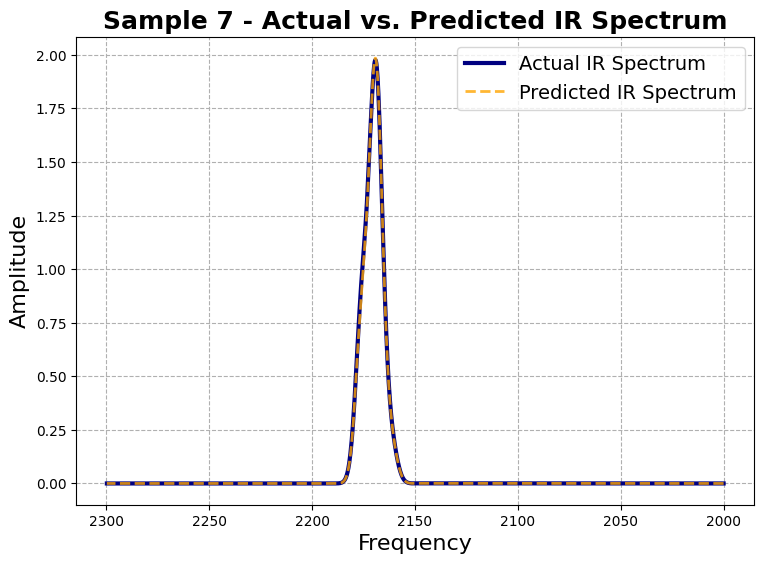

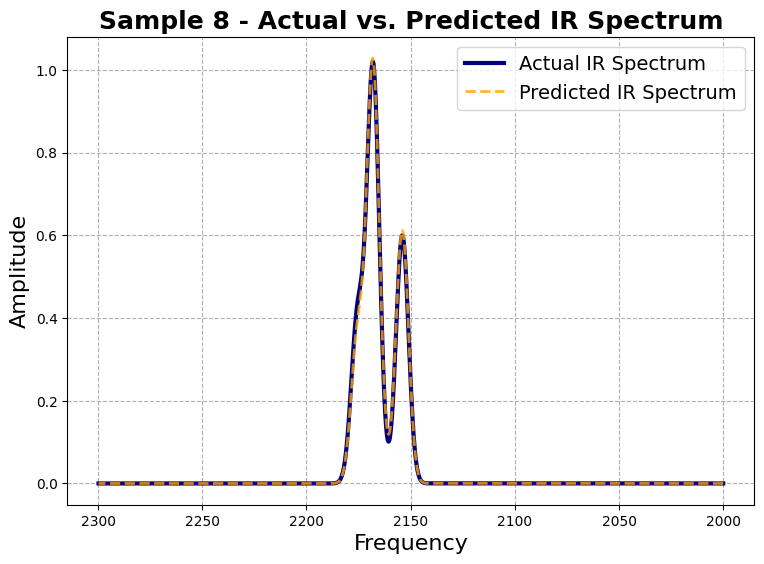

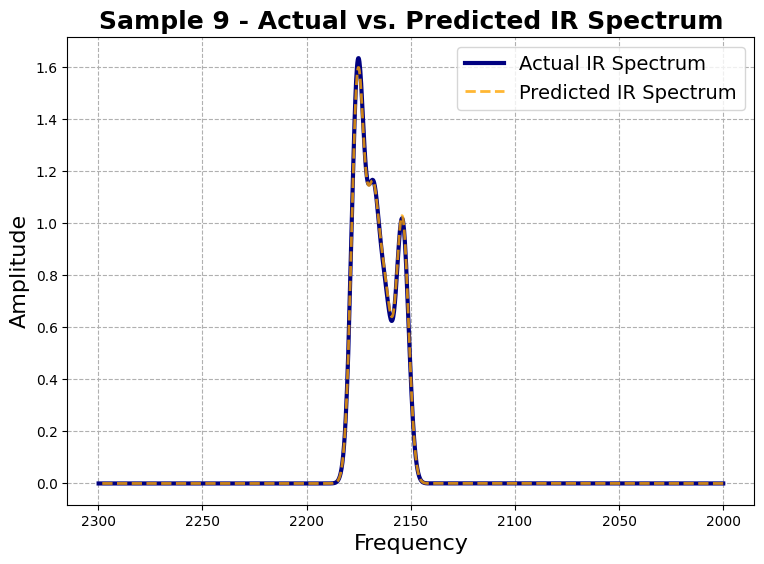

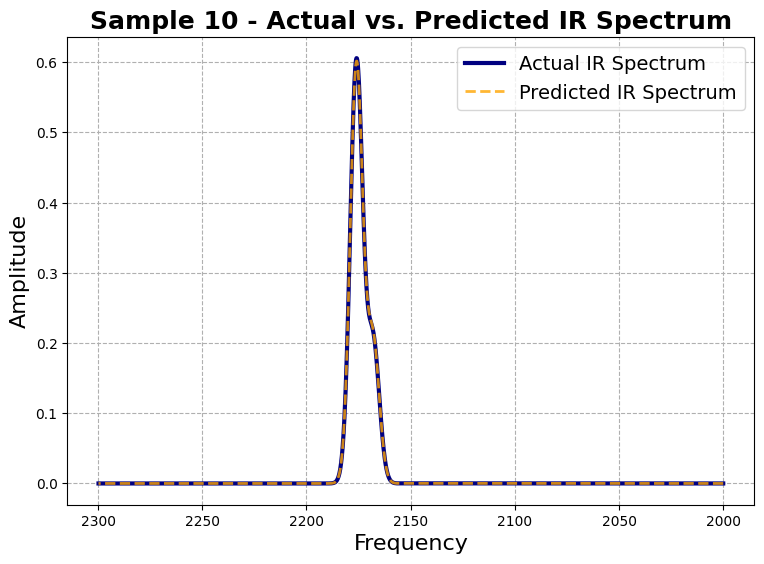

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, AveragePooling1D
from tensorflow.keras import regularizers
import random
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import itertools

np.random.seed(56)
random.seed(56)
tf.random.set_seed(56)

# Function to generate a spectrum as a sum of Gaussians
def generate_spectrum_gaussians(amplitudes, centers):
    widthG = 18
    x_range = np.arange(2000, 2299.8, 0.2)
    return np.sum([amplitudes[i] * np.exp(-(x_range - centers[i])**2 / widthG) for i in range(len(centers))], axis=0)

def generate_multiple_spectra(amplitudes, centers):
    widthG = 18
    x_range = np.arange(2300, 2000, -0.2)  # Correct range generation

    all_spectra = []

    for i, center in enumerate(centers):
        if center == 2176:
            intensity_ratios = [5, 2, 1]
            frequencies = [2176, 2168, 2147]
        elif center == 2168:
            intensity_ratios = [3, 1]
            frequencies = [2168, 2147]
        else:
            intensity_ratios = [1]
            frequencies = [center]  # Directly use center if it doesn't match special cases

        # Adjust this line to correctly apply amplitude and intensity ratios
        spectrum = np.sum([amplitudes[i] * np.exp(-(x_range - frequency)**2 / widthG) * intensity_ratio for frequency, intensity_ratio in zip(frequencies, intensity_ratios)], axis=0)
        all_spectra.append(spectrum)

    final_spectrum = np.sum(all_spectra, axis=0)

    return final_spectrum

# Define specific frequencies and corresponding classes/labels
specificFrequencies = {
    2175: 'CeO2(110)red',
    2170: 'CeO2(110)ox',
    2176: 'CeO2(100)ox',
    2168: 'CeO2(100)red',
    2162: 'CeO2(111)red',
    2154: 'CeO2(111)ox'
}

# Define possible amplitudes
possible_amplitudes = [0, 0.2, 0.6, 1.0]

# Generate all possible combinations of amplitudes
amplitude_combinations = list(itertools.product(possible_amplitudes, repeat=len(specificFrequencies)))

# Exclude the combination where all amplitudes are 0.0
amplitude_combinations = [combo for combo in amplitude_combinations if sum(combo) > 0.0]

# Shuffle the amplitude combinations
random.shuffle(amplitude_combinations)

# Generate spectra data with corresponding amplitude vectors
spectraDataAmplitudesList = []
for amplitudes in amplitude_combinations:
    spectrum = generate_multiple_spectra(amplitudes, list(specificFrequencies.keys()))
    spectraDataAmplitudesList.append((spectrum, amplitudes))

# Shuffle the spectra data
random.shuffle(spectraDataAmplitudesList)

# Split the data into spectra and amplitudes
spectraData = np.array([data[0] for data in spectraDataAmplitudesList])
amplitudesData = np.array([data[1] for data in spectraDataAmplitudesList])

print("Shape of spectraData:", spectraData.shape)

num_samples, points_per_spectrum = spectraData.shape
num_specific_frequencies = len(specificFrequencies)
spectraData = np.reshape(spectraData, (num_samples, points_per_spectrum // num_specific_frequencies, num_specific_frequencies))

# Model Parameters
regularization_parameter = 0.0001

# Define the input shape based on spectraData's shape
input_shape = spectraData.shape[1:]

# Create the model
model = Sequential()

# Feature Extraction Part
# Three parallel 1D convolutional layers
for kernel_size in [5, 10, 15]:
    model.add(Conv1D(12, kernel_size, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(regularization_parameter)))

# Concatenate the outputs of the parallel layers
# Add additional 1D convolutional layers
model.add(Conv1D(12, 15, strides=1, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Conv1D(12, 15, strides=1, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))

# Average Pooling
model.add(AveragePooling1D(pool_size=2, strides=2))

# Flatten the output
model.add(Flatten())

# Quantification Stage
# Fully Connected Layers
model.add(Dense(4000, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Dense(num_specific_frequencies, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split  # Import train_test_split

class RMSECallback(Callback):
    def __init__(self, validation_data):
        super(RMSECallback, self).__init__()
        self.validation_data = validation_data
        self.losses = []
        self.rmse_values_train = []  # Store RMSE values for training
        self.rmse_values_val = []    # Store RMSE values for validation

    def on_epoch_end(self, epoch, logs=None):
        X_train, y_train = self.validation_data[0], self.validation_data[1]
        y_train_pred = self.model.predict(X_train)  # Predict on training data

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

        # Separate data for validation prediction
        X_val, y_val = self.validation_data[2], self.validation_data[3]
        y_val_pred = self.model.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

        self.rmse_values_train.append(rmse_train)  # Append training RMSE
        self.rmse_values_val.append(rmse_val)      # Append validation RMSE
        self.losses.append(logs['loss'])           # Append training loss
        print(f'Epoch {epoch + 1} - Loss: {logs["loss"]}, Training RMSE: {rmse_train}, Validation RMSE: {rmse_val}')

# Separate training and validation data
spectraData_train, spectraData_val, amplitudesData_train, amplitudesData_val = train_test_split(spectraData, amplitudesData, test_size=0.2)

# Instantiate the RMSECallback with both training and validation data
# rmse_callback = RMSECallback(validation_data=(spectraData_train, amplitudesData_train, spectraData_val, amplitudesData_val))

# Train the model and store the training history
history = model.fit(spectraData_train, amplitudesData_train, epochs=25, validation_data=(spectraData_val, amplitudesData_val),  verbose=0)

# Plotting the training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# # Plotting the training and validation RMSE
# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(rmse_callback.rmse_values_train) + 1), rmse_callback.rmse_values_train, label='Training RMSE')
# plt.plot(range(1, len(rmse_callback.rmse_values_val) + 1), rmse_callback.rmse_values_val, label='Validation RMSE')
# plt.title('Model RMSE')
# plt.xlabel('Epochs')
# plt.ylabel('RMSE')
# plt.legend()

# plt.tight_layout()
# plt.show()






# Save the model
model.save('CNN_Model_systematic.h5')

# Generate new spectra data for testing
num_new_spectra = 1000
new_spectra_data_amplitudes_list = []
for _ in range(num_new_spectra):
    amplitudes = random.choice(amplitude_combinations)  # Correctly select a random amplitude combination
    spectrum = generate_multiple_spectra(amplitudes, list(specificFrequencies.keys()))
    new_spectra_data_amplitudes_list.append((spectrum, amplitudes))

# Split the new data into spectra and amplitudes
new_spectra_data = np.array([data[0] for data in new_spectra_data_amplitudes_list])
new_amplitudes_data = np.array([data[1] for data in new_spectra_data_amplitudes_list])

num_samples_new, points_per_spectrum_new = new_spectra_data.shape
new_spectra_data = np.reshape(new_spectra_data, (num_samples_new, points_per_spectrum_new // num_specific_frequencies, num_specific_frequencies))

# Predict amplitudes for the new spectra
predicted_amplitudes_new = model.predict(new_spectra_data)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(new_amplitudes_data, predicted_amplitudes_new))
print(f"Root Mean Squared Error (RMSE) on 1000 new spectra: {rmse}")

# Calculate R2 Score
r2 = r2_score(new_amplitudes_data, predicted_amplitudes_new)
print(f"R2 Score on 1000 new spectra: {r2}")


import numpy as np
import matplotlib.pyplot as plt

# Function to generate a spectrum as a sum of Gaussians
def generate_spectrum_gaussians(amplitudes, centers, x_range):
    widthG = 18
    return np.sum([amplitudes[i] * np.exp(-(x_range - centers[i])**2 / widthG) for i in range(len(centers))], axis=0)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_curves(actual, predicted, specificFrequencies, x_range):
    num_samples = min(len(actual), len(predicted))

    # Set font style to sans-serif for better clarity
    plt.rcParams['font.family'] = 'sans-serif'

    for i in range(num_samples):
        plt.figure(figsize=(8, 6))

        # Use contrasting colors and styles for actual vs predicted
        plt.plot(x_range, actual[i], label='Actual IR Spectrum', color='navy', linestyle='-', linewidth=3)
        plt.plot(x_range, predicted[i], label='Predicted IR Spectrum', color='orange', linestyle='--', linewidth=2, alpha=0.8)

        # Adjust font sizes for better clarity
        plt.xlabel('Wavenumber (CM-1)', fontsize=16)
        plt.ylabel('Intensity', fontsize=16)
        plt.grid(True, which="both", ls="--")
        plt.gca().invert_xaxis()  # Invert the x-axis
        plt.legend(fontsize=14)

        # Increase spacing around plot for better readability
        plt.tight_layout(pad=2)

        plt.show()




# Selecting 10 random samples for plotting
num_samples_to_plot = 10
selected_indices = np.random.choice(len(new_amplitudes_data), num_samples_to_plot, replace=False)

# Extracting actual and predicted curves for selected samples
actual_to_plot = [generate_spectrum_gaussians(amplitudes, list(specificFrequencies.keys()), np.arange(2000, 2299.8, 0.2)) for amplitudes in new_amplitudes_data[selected_indices]]
predicted_to_plot = [generate_spectrum_gaussians(amplitudes, list(specificFrequencies.keys()), np.arange(2000, 2299.8, 0.2)) for amplitudes in predicted_amplitudes_new[selected_indices]]

# Plotting actual and predicted curves for selected samples
plot_curves(actual_to_plot, predicted_to_plot, specificFrequencies, np.arange(2000, 2299.8, 0.2))



Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - loss: 1.5964 - val_loss: 0.1198
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - loss: 0.1063 - val_loss: 0.0796
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 0.0763 - val_loss: 0.0657
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - loss: 0.0653 - val_loss: 0.0698
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - loss: 0.0663 - val_loss: 0.0593
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - loss: 0.0594 - val_loss: 0.0593
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - loss: 0.0595 - val_loss: 0.0564
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - loss: 0.0569 - val_loss: 0.0575
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - loss: 0.0575 - val_loss: 0.0550
Epoch 10/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - loss: 0.0549 - val_loss: 0.0547
Epoch 11/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - loss: 0.0544 - val_loss: 0.0540
Epoch 12/20
103/103

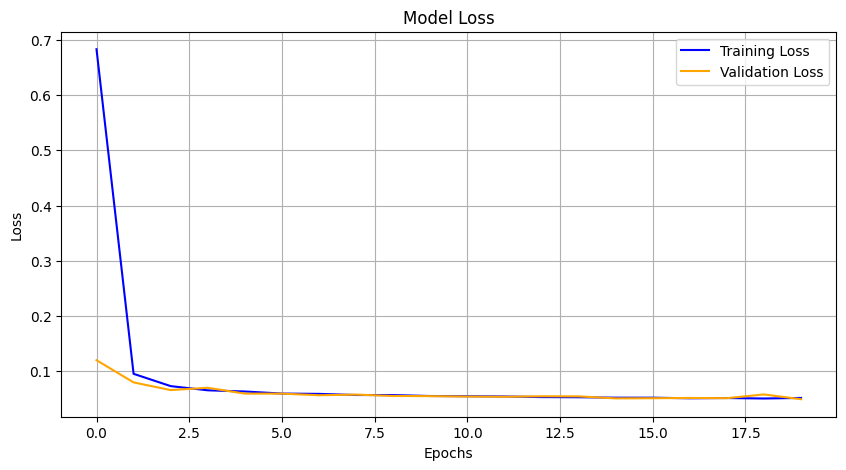

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


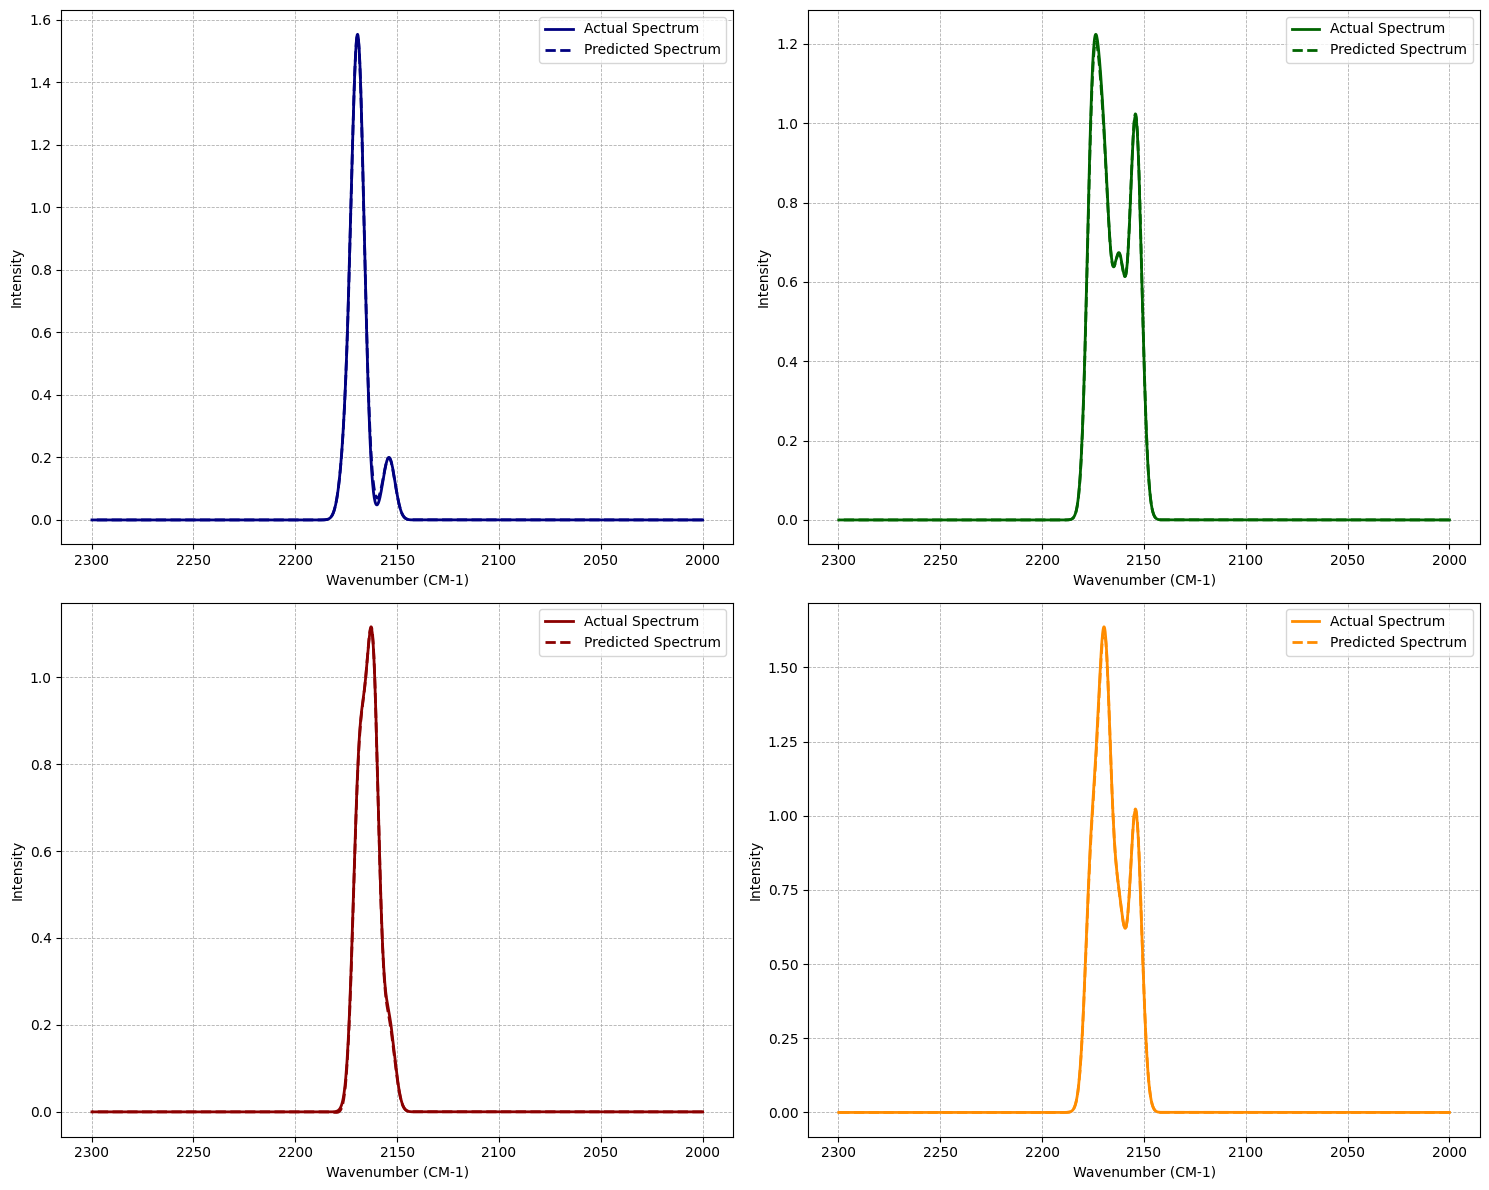

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, AveragePooling1D
from tensorflow.keras import regularizers
import random
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(56)
random.seed(56)
tf.random.set_seed(56)

# Function to generate a spectrum as a sum of Gaussians
def generate_spectrum_gaussians(amplitudes, centers, x_range=None):
    widthG = 18
    if x_range is None:
        x_range = np.arange(2000, 2299.8, 0.2)
    return np.sum([amplitudes[i] * np.exp(-(x_range - centers[i])**2 / widthG) for i in range(len(centers))], axis=0)

# Define specific frequencies and corresponding labels
specificFrequencies = {
    2175: 'CeO2(110)red',
    2170: 'CeO2(110)ox',
    2176: 'CeO2(100)ox',
    2168: 'CeO2(100)red',
    2162: 'CeO2(111)red',
    2154: 'CeO2(111)ox'
}

# Define possible amplitudes and generate all combinations
possible_amplitudes = [0, 0.2, 0.6, 1.0]
amplitude_combinations = list(itertools.product(possible_amplitudes, repeat=len(specificFrequencies)))
amplitude_combinations = [combo for combo in amplitude_combinations if sum(combo) > 0.0]  # Exclude all-zero combinations
random.shuffle(amplitude_combinations)  # Shuffle the amplitude combinations

# Generate spectra data with corresponding amplitude vectors
spectraDataAmplitudesList = []
for amplitudes in amplitude_combinations:
    spectrum = generate_spectrum_gaussians(amplitudes, list(specificFrequencies.keys()))
    spectraDataAmplitudesList.append((spectrum, amplitudes))

# Shuffle the spectra data
random.shuffle(spectraDataAmplitudesList)

# Split the data into spectra and amplitudes
spectraData = np.array([data[0] for data in spectraDataAmplitudesList])
amplitudesData = np.array([data[1] for data in spectraDataAmplitudesList])

# Model Parameters
regularization_parameter = 0.0001

# Define the input shape based on spectraData's shape
input_shape = (spectraData.shape[1], 1)

# Reshape spectra data for CNN input
spectraData = spectraData.reshape((spectraData.shape[0], spectraData.shape[1], 1))

# Create the model
model = Sequential()
model.add(Conv1D(12, 5, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Conv1D(12, 10, strides=1, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(AveragePooling1D(pool_size=2, strides=2))
model.add(Conv1D(12, 15, strides=1, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Flatten())
model.add(Dense(400, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Dense(len(specificFrequencies), activation='linear', kernel_regularizer=regularizers.l1(regularization_parameter)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Split the data into training and validation sets
spectraData_train, spectraData_val, amplitudesData_train, amplitudesData_val = train_test_split(spectraData, amplitudesData, test_size=0.2)

# Train the model
history = model.fit(spectraData_train, amplitudesData_train, epochs=20, validation_data=(spectraData_val, amplitudesData_val), verbose=1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate new spectra data for testing
num_new_spectra = 4
new_spectra_data_amplitudes_list = []
for _ in range(num_new_spectra):
    amplitudes = random.choice(amplitude_combinations)
    spectrum = generate_spectrum_gaussians(amplitudes, list(specificFrequencies.keys()))
    new_spectra_data_amplitudes_list.append((spectrum, amplitudes))

# Split the new data into spectra and amplitudes
new_spectra_data = np.array([data[0] for data in new_spectra_data_amplitudes_list])
new_amplitudes_data = np.array([data[1] for data in new_spectra_data_amplitudes_list])

# Reshape new spectra data for prediction
new_spectra_data = new_spectra_data.reshape((new_spectra_data.shape[0], new_spectra_data.shape[1], 1))

# Predict amplitudes for the new spectra
predicted_amplitudes_new = model.predict(new_spectra_data)

# Plotting actual vs predicted spectra for the new data
x_range = np.arange(2000, 2299.8, 0.2)
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
colors = ['navy', 'darkgreen', 'darkred', 'darkorange']
line_styles = ['-', '--']

for i in range(num_new_spectra):
    ax = axs[i // 2, i % 2]
    ax.plot(x_range, new_spectra_data[i].flatten(), label='Actual Spectrum', color=colors[i], linestyle=line_styles[0], linewidth=2)
    predicted_spectrum = generate_spectrum_gaussians(predicted_amplitudes_new[i], list(specificFrequencies.keys()), x_range)
    ax.plot(x_range, predicted_spectrum, label='Predicted Spectrum', color=colors[i], linestyle=line_styles[1], linewidth=2)
    ax.set_xlabel("Wavenumber (CM-1)")
    ax.set_ylabel("Intensity")
    ax.invert_xaxis()
    ax.grid(True, which="both", linestyle='--', linewidth=0.6)
    ax.legend()

plt.tight_layout()
plt.show()


Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 1.6082 - val_loss: 0.1447
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 0.1302 - val_loss: 0.1092
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 0.1051 - val_loss: 0.0942
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - loss: 0.0952 - val_loss: 0.0887
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - loss: 0.0910 - val_loss: 0.0873
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - loss: 0.0883 - val_loss: 0.0845
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - loss: 0.0856 - val_loss: 0.0813
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - loss: 0.0836 - val_loss: 0.0803
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - loss: 0.0820 - val_loss: 0.0794
Epoch 10/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - loss: 0.0809 - val_loss: 0.0783
Epoch 11/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - loss: 0.0797 - val_loss: 0.0781
Epoch 12/20
103/103

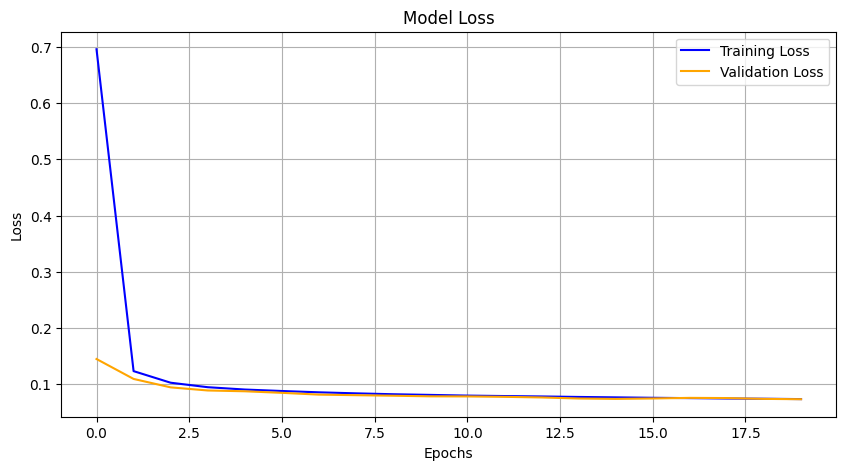

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


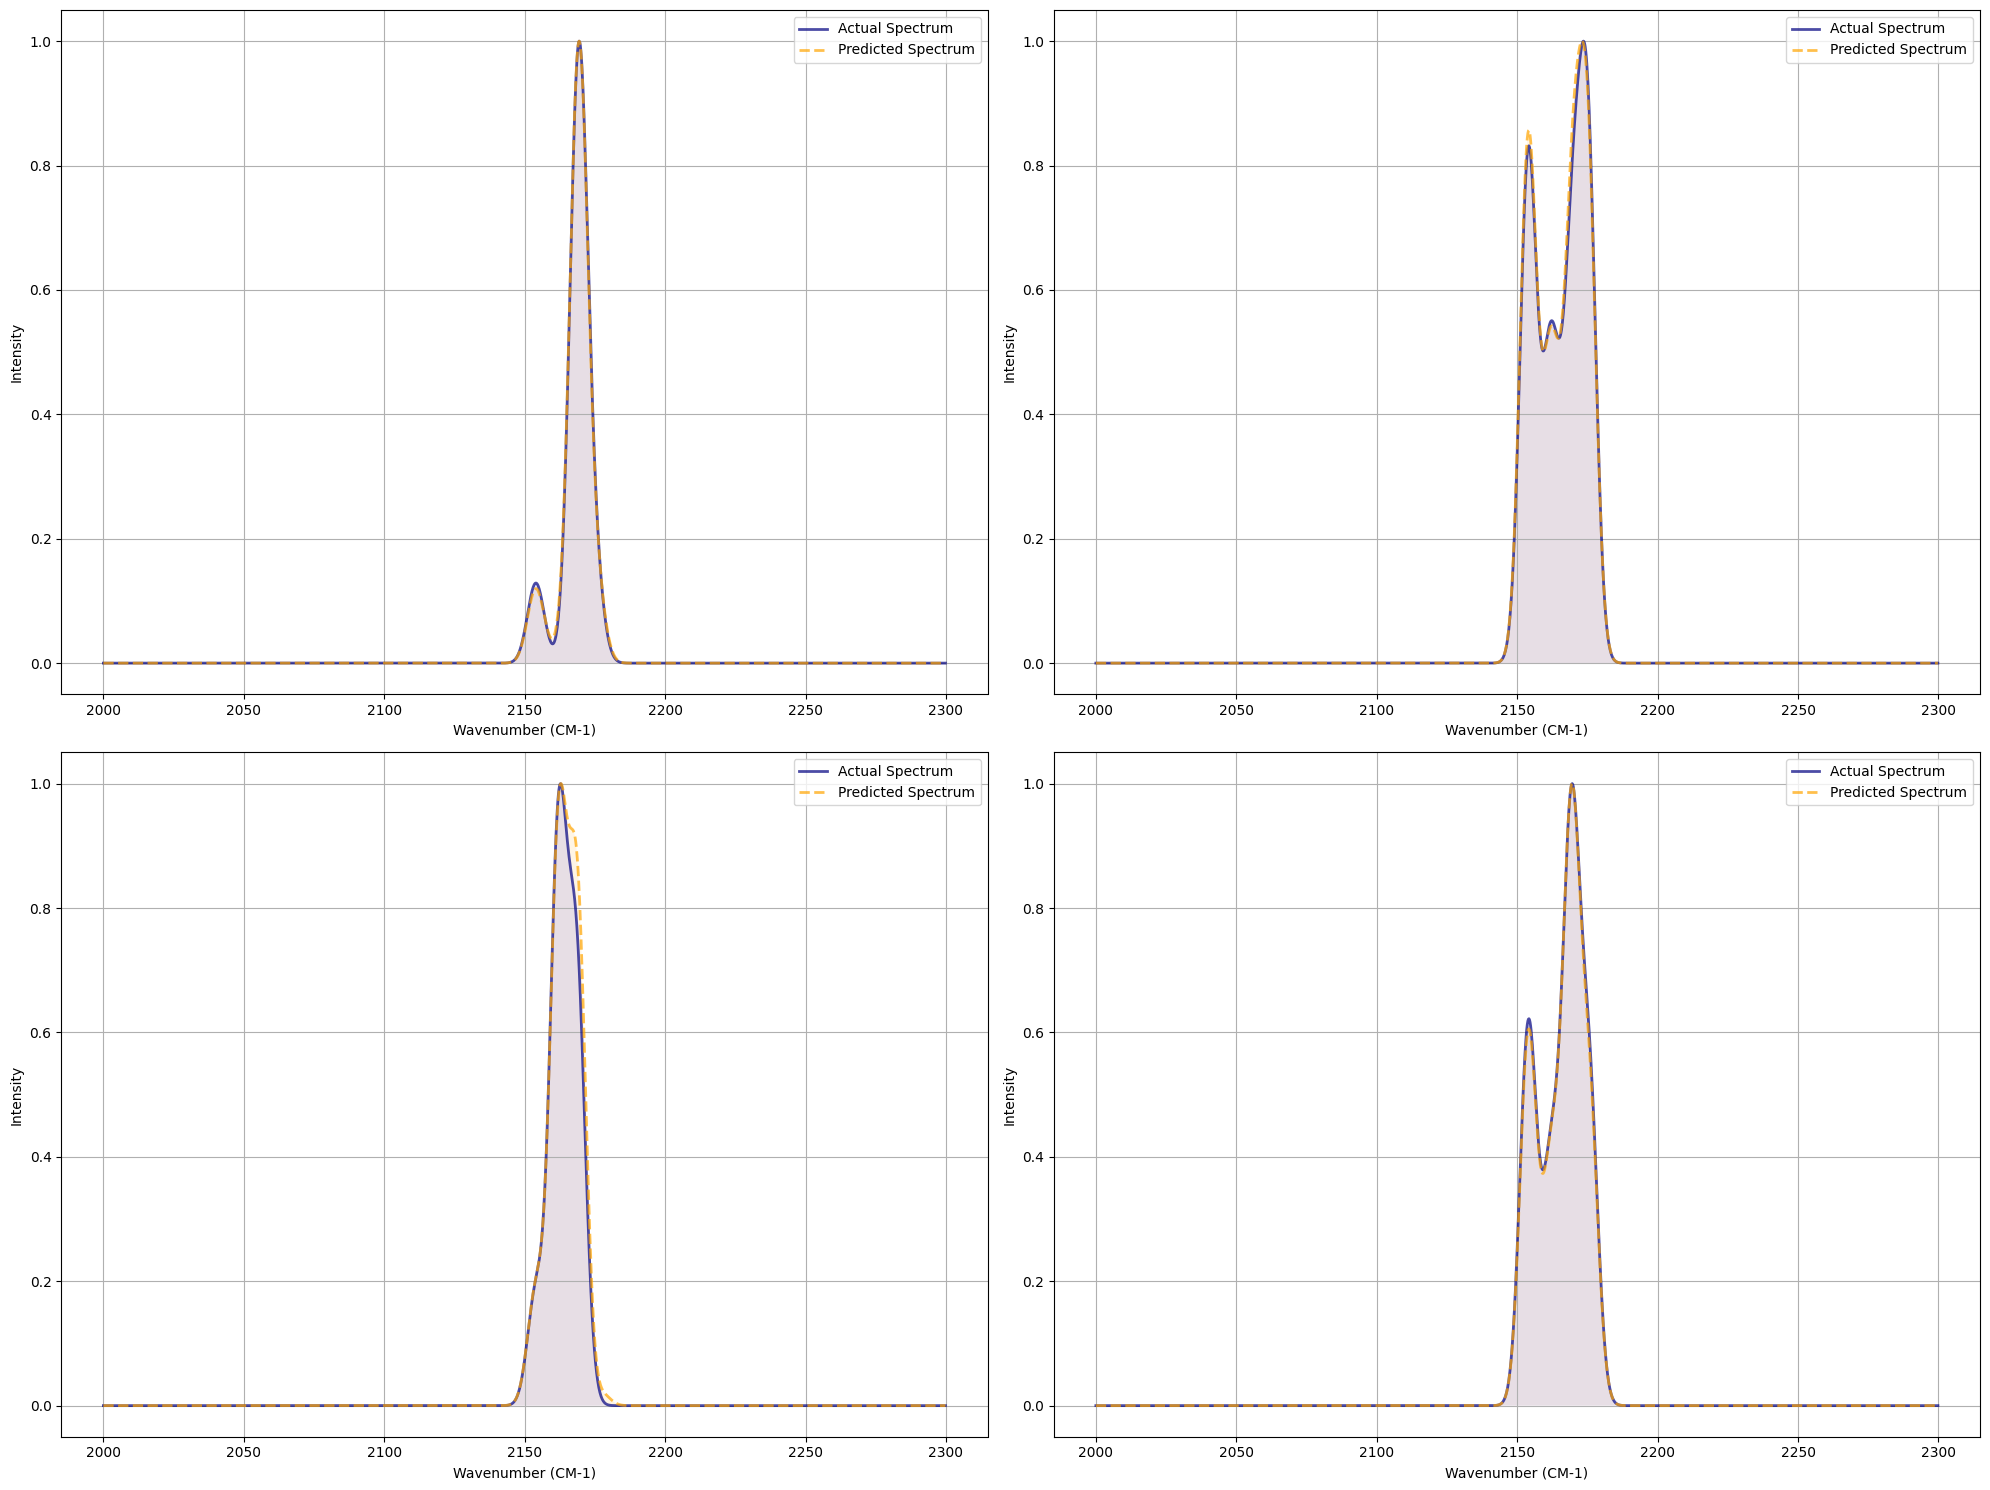

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, AveragePooling1D
from tensorflow.keras import regularizers
import random
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

# Set random seeds for reproducibility
np.random.seed(56)
random.seed(56)
tf.random.set_seed(56)

# Function to generate a spectrum as a sum of Gaussians
def generate_spectrum_gaussians(amplitudes, centers, x_range=None):
    widthG = 18
    if x_range is None:
        x_range = np.arange(2000, 2299.8, 0.2)
    return np.sum([amplitudes[i] * np.exp(-(x_range - centers[i])**2 / widthG) for i in range(len(centers))], axis=0)

# Define specific frequencies and corresponding labels
specificFrequencies = {
    2175: 'CeO2(110)red',
    2170: 'CeO2(110)ox',
    2176: 'CeO2(100)ox',
    2168: 'CeO2(100)red',
    2162: 'CeO2(111)red',
    2154: 'CeO2(111)ox'
}

# Define possible amplitudes and generate all combinations
possible_amplitudes = [0, 0.2, 0.6, 1.0]
amplitude_combinations = list(itertools.product(possible_amplitudes, repeat=len(specificFrequencies)))
amplitude_combinations = [combo for combo in amplitude_combinations if sum(combo) > 0.0]  # Exclude all-zero combinations
random.shuffle(amplitude_combinations)  # Shuffle the amplitude combinations

# Generate spectra data with corresponding amplitude vectors
spectraDataAmplitudesList = []
for amplitudes in amplitude_combinations:
    spectrum = generate_spectrum_gaussians(amplitudes, list(specificFrequencies.keys()))
    # Normalize the spectrum between 0 and 1
    spectrum = (spectrum - np.min(spectrum)) / (np.max(spectrum) - np.min(spectrum))
    spectraDataAmplitudesList.append((spectrum, amplitudes))

# Shuffle the spectra data
random.shuffle(spectraDataAmplitudesList)

# Split the data into spectra and amplitudes
spectraData = np.array([data[0] for data in spectraDataAmplitudesList])
amplitudesData = np.array([data[1] for data in spectraDataAmplitudesList])

# Model Parameters
regularization_parameter = 0.0001

# Define the input shape based on spectraData's shape
input_shape = (spectraData.shape[1], 1)

# Reshape spectra data for CNN input
spectraData = spectraData.reshape((spectraData.shape[0], spectraData.shape[1], 1))

# Create the model
model = Sequential()
model.add(Conv1D(12, 5, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Conv1D(12, 10, strides=1, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(AveragePooling1D(pool_size=2, strides=2))
model.add(Conv1D(12, 15, strides=1, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Flatten())
model.add(Dense(400, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Dense(len(specificFrequencies), activation='linear', kernel_regularizer=regularizers.l1(regularization_parameter)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Split the data into training and validation sets
spectraData_train, spectraData_val, amplitudesData_train, amplitudesData_val = train_test_split(spectraData, amplitudesData, test_size=0.2)

# Train the model
history = model.fit(spectraData_train, amplitudesData_train, epochs=20, validation_data=(spectraData_val, amplitudesData_val), verbose=1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate new spectra data for testing
num_new_spectra = 4
new_spectra_data_amplitudes_list = []
for _ in range(num_new_spectra):
    amplitudes = random.choice(amplitude_combinations)
    spectrum = generate_spectrum_gaussians(amplitudes, list(specificFrequencies.keys()))
    # Normalize the spectrum between 0 and 1
    spectrum = (spectrum - np.min(spectrum)) / (np.max(spectrum) - np.min(spectrum))
    new_spectra_data_amplitudes_list.append((spectrum, amplitudes))

# Split the new data into spectra and amplitudes
new_spectra_data = np.array([data[0] for data in new_spectra_data_amplitudes_list])
new_amplitudes_data = np.array([data[1] for data in new_spectra_data_amplitudes_list])

# Reshape new spectra data for prediction
new_spectra_data = new_spectra_data.reshape((new_spectra_data.shape[0], new_spectra_data.shape[1], 1))

# Predict amplitudes for the new spectra
predicted_amplitudes_new = model.predict(new_spectra_data)

# Plotting actual vs predicted spectra for the new data in 4 separate 2D plots with better distinction
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
x_range = np.arange(2000, 2299.8, 0.2)

for i in range(num_new_spectra):
    ax = axs[i // 2, i % 2]
    actual_spectrum = new_spectra_data[i].flatten()
    predicted_spectrum = generate_spectrum_gaussians(predicted_amplitudes_new[i], list(specificFrequencies.keys()), x_range)
    # Normalize the predicted spectrum between 0 and 1
    predicted_spectrum = (predicted_spectrum - np.min(predicted_spectrum)) / (np.max(predicted_spectrum) - np.min(predicted_spectrum))

    # Plot actual spectrum with filled area
    ax.plot(x_range, actual_spectrum, label='Actual Spectrum', linestyle='-', linewidth=2, color='navy', alpha=0.7)
    ax.fill_between(x_range, 0, actual_spectrum, facecolor='blue', alpha=0.1)

    # Plot predicted spectrum with filled area and slight offset
    ax.plot(x_range, predicted_spectrum, label='Predicted Spectrum', linestyle='--', linewidth=2, color='orange', alpha=0.7)
    ax.fill_between(x_range, 0, predicted_spectrum, facecolor='orange', alpha=0.1)

    ax.set_xlabel("Wavenumber (CM-1)")
    ax.set_ylabel("Intensity")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
